In [23]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
from scipy.misc import toimage

print(tf.__version__)

2.0.0-rc1


In [24]:
class Generator(keras.Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.n_f = 512
        self.n_k = 4

        # input z vector is [None, 100]
        self.dense1 = keras.layers.Dense(3 * 3 * self.n_f)
        self.conv2 = keras.layers.Conv2DTranspose(self.n_f // 2, 3, 2, 'valid')
        self.bn2 = keras.layers.BatchNormalization()
        self.conv3 = keras.layers.Conv2DTranspose(self.n_f // 4, self.n_k, 2, 'same')
        self.bn3 = keras.layers.BatchNormalization()
        self.conv4 = keras.layers.Conv2DTranspose(1, self.n_k, 2, 'same')

    def call(self, inputs, training=None):
        # [b, 100] => [b, 3, 3, 512]
        x = tf.nn.leaky_relu(tf.reshape(self.dense1(inputs), shape=[-1, 3, 3, self.n_f]))
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training))
        x = tf.tanh(self.conv4(x))
        return x


class Discriminator(keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_f = 64
        self.n_k = 4

        # input image is [-1, 28, 28, 1]
        self.conv1 = keras.layers.Conv2D(self.n_f, self.n_k, 2, 'same')
        self.conv2 = keras.layers.Conv2D(self.n_f * 2, self.n_k, 2, 'same')
        self.bn2 = keras.layers.BatchNormalization()
        self.conv3 = keras.layers.Conv2D(self.n_f * 4, self.n_k, 2, 'same')
        self.bn3 = keras.layers.BatchNormalization()
        self.flatten4 = keras.layers.Flatten()
        self.dense4 = keras.layers.Dense(1)

    def call(self, inputs, training=None):
        x = tf.nn.leaky_relu(self.conv1(inputs))
        x = tf.nn.leaky_relu(self.bn2(self.conv2(x), training=training))
        x = tf.nn.leaky_relu(self.bn3(self.conv3(x), training=training))
        x = self.dense4(self.flatten4(x))
        return x

In [25]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [26]:
def celoss_ones(logits, smooth=0.0):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                                  labels=tf.ones_like(logits)*(1.0 - smooth)))

def celoss_zeros(logits, smooth=0.0):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,
                                                                  labels=tf.zeros_like(logits)*(1.0 - smooth)))

def d_loss_fn(generator, discriminator, input_noise, real_image, is_trainig):
    fake_image = generator(input_noise, is_trainig)
    d_real_logits = discriminator(real_image, is_trainig)
    d_fake_logits = discriminator(fake_image, is_trainig)

    d_loss_real = celoss_ones(d_real_logits, smooth=0.1)
    d_loss_fake = celoss_zeros(d_fake_logits, smooth=0.0)
    loss = d_loss_real + d_loss_fake
    return loss

def g_loss_fn(generator, discriminator, input_noise, is_trainig):
    fake_image = generator(input_noise, is_trainig)
    d_fake_logits = discriminator(fake_image, is_trainig)
    loss = celoss_ones(d_fake_logits, smooth=0.1)
    return loss

In [27]:
def save_result(val_out, val_block_size, image_fn, color_mode):
    def preprocess(img):
        img = ((img + 1.0) * 127.5).astype(np.uint8)
        return img

    preprocesed = preprocess(val_out)
    final_image = np.array([])
    single_row = np.array([])
    for b in range(val_out.shape[0]):
        # concat image into a row
        if single_row.size == 0:
            single_row = preprocesed[b, :, :, :]
        else:
            single_row = np.concatenate((single_row, preprocesed[b, :, :, :]), axis=1)

        # concat image row to final_image
        if (b+1) % val_block_size == 0:
            if final_image.size == 0:
                final_image = single_row
            else:
                final_image = np.concatenate((final_image, single_row), axis=0)

            # reset single row
            single_row = np.array([])

    if final_image.shape[2] == 1:
        final_image = np.squeeze(final_image, axis=2)
    toimage(final_image, mode=color_mode).save(image_fn)

In [ ]:

tf.random.set_seed(22)
np.random.seed(22)
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
assert tf.__version__.startswith('2.')


# hyper parameters
z_dim = 100
epochs = 5000
batch_size = 128
learning_rate = 0.0002
is_training = True

# for validation purpose
val_block_size = 10
val_size = val_block_size * val_block_size

# load mnist data
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32) / 255.
db = tf.data.Dataset.from_tensor_slices(x_train).shuffle(batch_size*4).batch(batch_size).repeat()
db_iter = iter(db)
inputs_shape = [-1, 28, 28, 1]

# create generator & discriminator
generator = Generator()
generator.build(input_shape=(batch_size, z_dim))
generator.summary()
discriminator = Discriminator()
discriminator.build(input_shape=(batch_size, 28, 28, 1))
discriminator.summary()

# prepare optimizer
d_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)
g_optimizer = keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5)

for epoch in range(epochs):
    # no need labels
    batch_x = next(db_iter)
    # rescale images to -1 ~ 1
    batch_x = tf.reshape(batch_x, shape=inputs_shape)
    # -1 - 1
    batch_x = batch_x * 2.0 - 1.0
    # Sample random noise for G
    batch_z = tf.random.uniform(shape=[batch_size, z_dim], minval=-1., maxval=1.)

    with tf.GradientTape() as tape:
        d_loss = d_loss_fn(generator, discriminator, batch_z, batch_x, is_training)
    grads = tape.gradient(d_loss, discriminator.trainable_variables)
    d_optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))

    with tf.GradientTape() as tape:
        g_loss = g_loss_fn(generator, discriminator, batch_z, is_training)
    grads = tape.gradient(g_loss, generator.trainable_variables)
    g_optimizer.apply_gradients(zip(grads, generator.trainable_variables))

    if epoch % 1000 == 0:
        print("epoch:", epoch, 'd loss:', float(d_loss), 'g loss:', float(g_loss))

        # validation results at every epoch
        val_z = np.random.uniform(-1, 1, size=(val_size, z_dim))
        fake_image = generator(val_z, training=False)
        image_fn = './images/gan-val-{:03d}.png'.format(epoch + 1)
        save_result(fake_image.numpy(), val_block_size, image_fn, color_mode='L')

Model: "generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              multiple                  465408    
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  1179904   
_________________________________________________________________
batch_normalization_4 (Batch multiple                  1024      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr multiple                  524416    
_________________________________________________________________
batch_normalization_5 (Batch multiple                  512       
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr multiple                  2049      
Total params: 2,173,313
Trainable params: 2,172,545
Non-trainable params: 768
___________________________________________

/home/mi/workflow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


epoch: 1000 d loss: 1.3801114559173584 g loss: 0.7784891128540039


/home/mi/workflow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


epoch: 4000 d loss: 1.3762626647949219 g loss: 0.7814744710922241


/home/mi/workflow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


(60000, 28, 28)
5


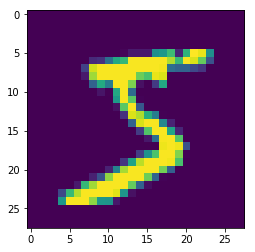

In [10]:
print(x_train.shape)
# print(x_train[0])
print(y_train[0])

import matplotlib.pyplot as plt
plt.imshow(x_train[0])
plt.show()

In [16]:
from scipy.misc import toimage
arr_image=x_train[0]
toimage(arr_image, mode="L").save("./xxx.jpg")

/home/mi/workflow/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [17]:
from PIL import Image
im = Image.fromarray(x_train[0])
im.save("yyy.jpeg")

In [18]:
import matplotlib
matplotlib.image.imsave('zzz.png', x_train[0])

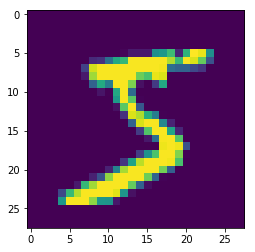

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img=mpimg.imread("zzz.png")
mpimg.imsave("ooo.jpg", img)

plt.imshow(img)
plt.show()


In [13]:
help(toimage)

Help on function toimage in module numpy.lib.utils:

toimage(*args, **kwds)
    `toimage` is deprecated!
    `toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use Pillow's ``Image.fromarray`` directly instead.
    
        Takes a numpy array and returns a PIL image.
    
        This function is only available if Python Imaging Library (PIL) is installed.
    
        The mode of the PIL image depends on the array shape and the `pal` and
        `mode` keywords.
    
        For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
        (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
        is given as 'F' or 'I' in which case a float and/or integer array is made.
    
        .. warning::
    
            This function uses `bytescale` under the hood to rescale images to use
            the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
            It will also cast data for 2-D images to ``uint32